# Use case: ERA5 small area 

Earth Data Hub offers an innovative and super-efficient way to access data.

Here we present how to best access the service in the simplest use case.

## Setup the environment

**If you haven't done it already, follow the [Getting started notebook](./00-getting-started.ipynb) to setup your environment and DestinE credentials.**

## Download 30 years of an ERA5 variable on a small area

Our use case is to compute various climatological averages of one ERA5 variable over a long period of time, e.g. the surface temperature over 30 years. Note that we will be  using the ERA5 single levels dataset that has more than 100 variable and every variable is almost 3TB in size. 

The best practice for downloading data form the Earth Data Hub comprise the following steps:
1. open the dataset using the code snippet found on the [ERA5 dataset page](https://earthdatahub.destine.eu/collections/era5/datasets/reanalysis-era5-single-levels)
2. select the variable
3. select the area of interest (optionally alligning it on chunk boundaries)
4. select the time interval of interest
5. download the data to memory (with `.persist()` or `.compute()`)
6. save the data or compute the result in memory

### Open the dataset

The following assumes you set up the EDH Personal Access Token in your _netrc_ file.

In [1]:
import xarray as xr

era5_single_levels_dataset = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
    chunks={},
    engine="zarr",
).drop_vars(["surface", "number"])
era5_single_levels_dataset

<xarray.Dataset> Size: 400TB
Dimensions:     (valid_time: 751680, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-09-30T23:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables: (12/128)
    alnid       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    alnip       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    aluvd       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    aluvp       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    anor        (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    ...          ...
    viiwn       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    vilwd       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    vilwe       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    vilwn       (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    z           (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
    zust        (valid_time, latitude, longitude) float32 3TB dask.array<chunksize=(4320, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2025-02-13T19:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

### Select and prepare the variable

Note that all operation are lazy, that is are not applied to the whole 3TB of data, but are just recorded for later use. Download and computations are only done when requested.

In [2]:
t2m_world = era5_single_levels_dataset.t2m
t2m_world

<xarray.DataArray 't2m' (valid_time: 751680, latitude: 721, longitude: 1440)> Size: 3TB
dask.array<open_dataset-t2m, shape=(751680, 721, 1440), dtype=float32, chunksize=(4320, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-09-30T23:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

### Select the area of interest

For example we are interested in the area of the Alps.

This a very convenient example as:
* it is a large enough area to be more interesting than a time-series of a single point,
* it is small enough to fit a single Zarr chunk, so the notebook can be run even with a slow internet connection,
* when plotted it is easy to identify even without adding coastlines and country borders that will make the notebook more complex.

In [3]:
aoi_selection = {
    "latitude": slice(49, 43),  # NOTE: ERA5 has a descending latitude coordinate
    "longitude": slice(5, 15),
}
t2m_aoi = t2m_world.sel(aoi_selection)
t2m_aoi

<xarray.DataArray 't2m' (valid_time: 751680, latitude: 25, longitude: 41)> Size: 3GB
dask.array<getitem, shape=(751680, 25, 41), dtype=float32, chunksize=(4320, 25, 41), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-09-30T23:...
  * latitude    (latitude) float64 200B 49.0 48.75 48.5 ... 43.5 43.25 43.0
  * longitude   (longitude) float64 328B 5.0 5.25 5.5 5.75 ... 14.5 14.75 15.0
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

Note that the data size is not much smaller, we went from 3TB for global data to 3GB of our small area of interest.

We plot the map of the temperature at one time to double check that the selection is correct:

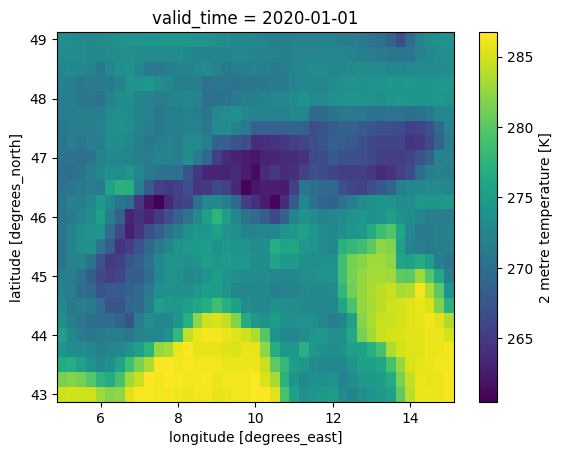

In [4]:
t2m_aoi.sel(valid_time="2020-01-01T00:00:00").plot()

### Optional: allign the area of interest on chunk boundaries

This a pro move and you can skip it.

When accessing the data in Zarr you always dowload whole chunks, even if you are only interestind in part of them. In the case of ERA5 single level the spatial chunks are `(64, 64)` in size and even if you can read above that your DataArray in only 2GB of data you are most probably donwloading more data and then throwing a part of it away.

You can use the following (not very nice) code to grow your area of interest to the boundaries of the Zarr chunks, so you use all the data you donwload. Note that now you also have the size of the data that would be downloaded is it was not compressed (the data is in fact compressed so actual downlaod is smaller).

In [5]:
def align_indexer(step, indexer):
    if not isinstance(indexer, slice):
        return indexer
    assert indexer.step is None
    start = indexer.start // step * step if indexer.start else indexer.start
    stop = (indexer.stop // step + 1) * step if indexer.stop else indexer.stop
    return slice(start, stop)


query_results = xr.core.indexing.map_index_queries(
    t2m_world, indexers=aoi_selection, method=None, tolerance=None
)
print(query_results.dim_indexers)

aoi_iselection = {
    dim: align_indexer(64, query_results.dim_indexers[dim])
    for dim in query_results.dim_indexers
}
print(aoi_iselection)

t2m_aoi = t2m_world.isel(aoi_iselection)
t2m_aoi

{'latitude': slice(164, 189, None), 'longitude': slice(20, 61, None)}
{'latitude': slice(128, 192, None), 'longitude': slice(0, 64, None)}


<xarray.DataArray 't2m' (valid_time: 751680, latitude: 64, longitude: 64)> Size: 12GB
dask.array<getitem, shape=(751680, 64, 64), dtype=float32, chunksize=(4320, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6MB 1940-01-01 ... 2025-09-30T23:...
  * latitude    (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude   (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

So, the full time-series for a whole chunk is really 11.5GB, not 2GB.

Let's have a look at the area of the whole chunk.

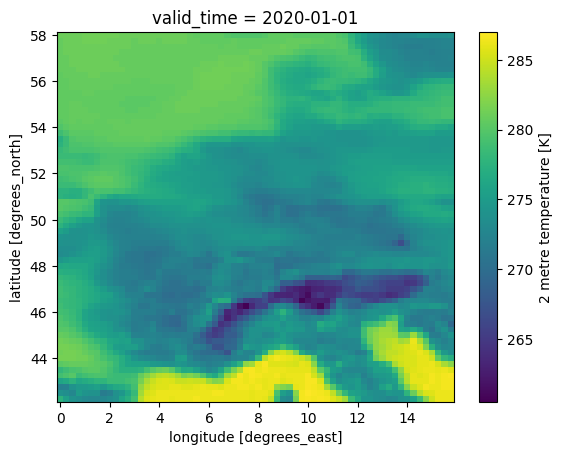

In [6]:
t2m_aoi.sel(valid_time="2020-01-01T00:00:00").plot()

Great! A single 64x64 chunk gets a big part of central Europe.

### Select the time interval of interest

We take one of the typical 30 year periods to compute climatologies and finally we have a definition of the data we want to download.

In [7]:
t2m_aoi_toi = t2m_aoi.sel(valid_time=slice("1981", "2010"))
t2m_aoi_toi

<xarray.DataArray 't2m' (valid_time: 262968, latitude: 64, longitude: 64)> Size: 4GB
dask.array<getitem, shape=(262968, 64, 64), dtype=float32, chunksize=(4320, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:...
  * latitude    (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude   (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

From the representation above we learn a few things:
1. the uncompressed data to be downloaded, e.g. 4GB (compression depends on the dataset and the variable)
2. the number of chunks to be downloaded, e.g. 62

### Download the data to memory

Finally we are ready to download only the data that we are interested in, in memory.

The best practice is to call the `.compute()` method load the data into a numpy array in memory.

**This operation is the slow one. It takes up to 20 minutes on a 8 Mbps connection.**

It depends on the download speed of your internet connection and on the load on the Earth Data Hub. The closer you are to the data the faster it is, and this is one of the reason the EDH is best suited to be used from within the DestinE platform.

In [8]:
%%time

t2m_aoi_toi_data = t2m_aoi_toi.compute()

CPU times: user 1min 11s, sys: 39.3 s, total: 1min 50s
Wall time: 19min 20s


### Perform any computation

#### Prepare the raw data 

In [9]:
t2m_aoi_toi_data_C = t2m_aoi_toi_data - 273.15
t2m_aoi_toi_data_C.attrs["units"] = "°C"
t2m_aoi_toi_data_C.attrs["long_name"] = "surface temperature"
t2m_aoi_toi_data_C

<xarray.DataArray 't2m' (valid_time: 262968, latitude: 64, longitude: 64)> Size: 4GB
array([[[ 2.600006 ,  2.600006 ,  2.350006 , ...,  1.6000061,
          1.6000061,  1.8500061],
        [ 2.350006 ,  2.350006 ,  2.100006 , ...,  1.1000061,
          1.3500061,  1.6000061],
        [ 2.850006 ,  2.850006 ,  2.850006 , ...,  1.1000061,
          1.3500061,  1.6000061],
        ...,
        [-6.149994 , -7.149994 , -5.899994 , ..., 10.350006 ,
         10.350006 , 10.850006 ],
        [-2.649994 , -5.649994 , -5.649994 , ...,  9.850006 ,
         10.100006 , 10.350006 ],
        [-1.3999939, -1.1499939, -1.1499939, ...,  9.850006 ,
         10.100006 , 10.100006 ]],

       [[ 3.350006 ,  3.350006 ,  3.100006 , ...,  1.8500061,
          1.8500061,  2.100006 ],
        [ 2.850006 ,  2.850006 ,  2.850006 , ...,  1.1000061,
          1.3500061,  1.6000061],
        [ 3.100006 ,  3.100006 ,  3.100006 , ...,  1.1000061,
          1.3500061,  1.6000061],
...
        [-2.899994 , -3.149994 , -4.149994 , ..., 10.600006 ,
         10.600006 , 10.350006 ],
        [-2.149994 , -1.8999939, -2.149994 , ..., 10.850006 ,
         10.600006 , 10.600006 ],
        [ 1.6000061,  1.3500061,  0.8500061, ..., 10.850006 ,
         11.100006 , 11.100006 ]],

       [[ 6.100006 ,  6.100006 ,  6.100006 , ...,  2.100006 ,
          2.100006 ,  2.100006 ],
        [ 6.350006 ,  6.350006 ,  6.350006 , ...,  1.8500061,
          2.100006 ,  2.100006 ],
        [ 6.600006 ,  6.600006 ,  6.600006 , ...,  1.6000061,
          1.8500061,  1.8500061],
        ...,
        [-2.649994 , -3.149994 , -4.149994 , ..., 10.600006 ,
         10.600006 , 10.350006 ],
        [-2.149994 , -2.149994 , -2.649994 , ..., 10.850006 ,
         10.600006 , 10.600006 ],
        [ 1.6000061,  1.3500061,  1.1000061, ..., 10.850006 ,
         11.100006 , 11.100006 ]]], shape=(262968, 64, 64), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:...
  * latitude    (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude   (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
Attributes:
    units:      °C
    long_name:  surface temperature

#### Monthly climatology

In [10]:
%%time

t2m_aoi_toi_month_mean = t2m_aoi_toi_data_C.groupby("valid_time.month").mean()
t2m_aoi_toi_month_mean

CPU times: user 1.58 s, sys: 1.84 s, total: 3.42 s
Wall time: 3.91 s


<xarray.DataArray 't2m' (month: 12, latitude: 64, longitude: 64)> Size: 197kB
array([[[ 6.288259  ,  6.2655263 ,  6.240828  , ..., -2.0513759 ,
         -2.0611925 , -1.9692771 ],
        [ 6.3108635 ,  6.2922163 ,  6.27405   , ..., -2.3265693 ,
         -2.1509356 , -1.99063   ],
        [ 6.3064957 ,  6.2937474 ,  6.2838955 , ..., -2.0919871 ,
         -1.8727889 , -1.7653532 ],
        ...,
        [-1.8969178 , -2.121505  , -2.228031  , ..., 10.799617  ,
         10.869887  , 10.938212  ],
        [ 0.09067598, -0.7740673 , -1.408502  , ..., 10.838088  ,
         10.922215  , 10.97718   ],
        [ 3.3619459 ,  3.0402527 ,  2.559864  , ..., 10.786295  ,
         11.120574  , 11.141419  ]],

       [[ 5.6336017 ,  5.6165032 ,  5.596589  , ..., -2.231605  ,
         -2.2170837 , -2.1127627 ],
        [ 5.637337  ,  5.6220965 ,  5.6083694 , ..., -2.428955  ,
         -2.2581418 , -2.0877748 ],
        [ 5.6229796 ,  5.6114917 ,  5.6005077 , ..., -2.184466  ,
         -1.9906456 , -1.8576753 ],
...
        [ 1.6761147 ,  1.6248493 ,  1.5938549 , ..., 14.559125  ,
         14.629953  , 14.75694   ],
        [ 3.8093693 ,  3.0911176 ,  2.5243354 , ..., 14.595673  ,
         14.669233  , 14.744522  ],
        [ 7.1052294 ,  6.92342   ,  6.508158  , ..., 14.56715   ,
         14.892226  , 14.893728  ]],

       [[ 6.9883924 ,  6.957408  ,  6.9255514 , ..., -0.9601666 ,
         -1.0348064 , -0.9644306 ],
        [ 7.0654225 ,  7.0407953 ,  7.017053  , ..., -1.3954798 ,
         -1.2288812 , -1.1139711 ],
        [ 7.105253  ,  7.085037  ,  7.066901  , ..., -1.1627448 ,
         -0.93017894, -0.904515  ],
        ...,
        [-1.1380607 , -1.3911052 , -1.4459637 , ..., 12.010782  ,
         12.082196  , 12.163392  ],
        [ 0.77346355, -0.15559494, -0.76517284, ..., 12.031454  ,
         12.117226  , 12.1698    ],
        [ 3.9854248 ,  3.6859438 ,  3.2221136 , ..., 11.975063  ,
         12.313679  , 12.315673  ]]], shape=(12, 64, 64), dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude  (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
Attributes:
    units:      °C
    long_name:  surface temperature

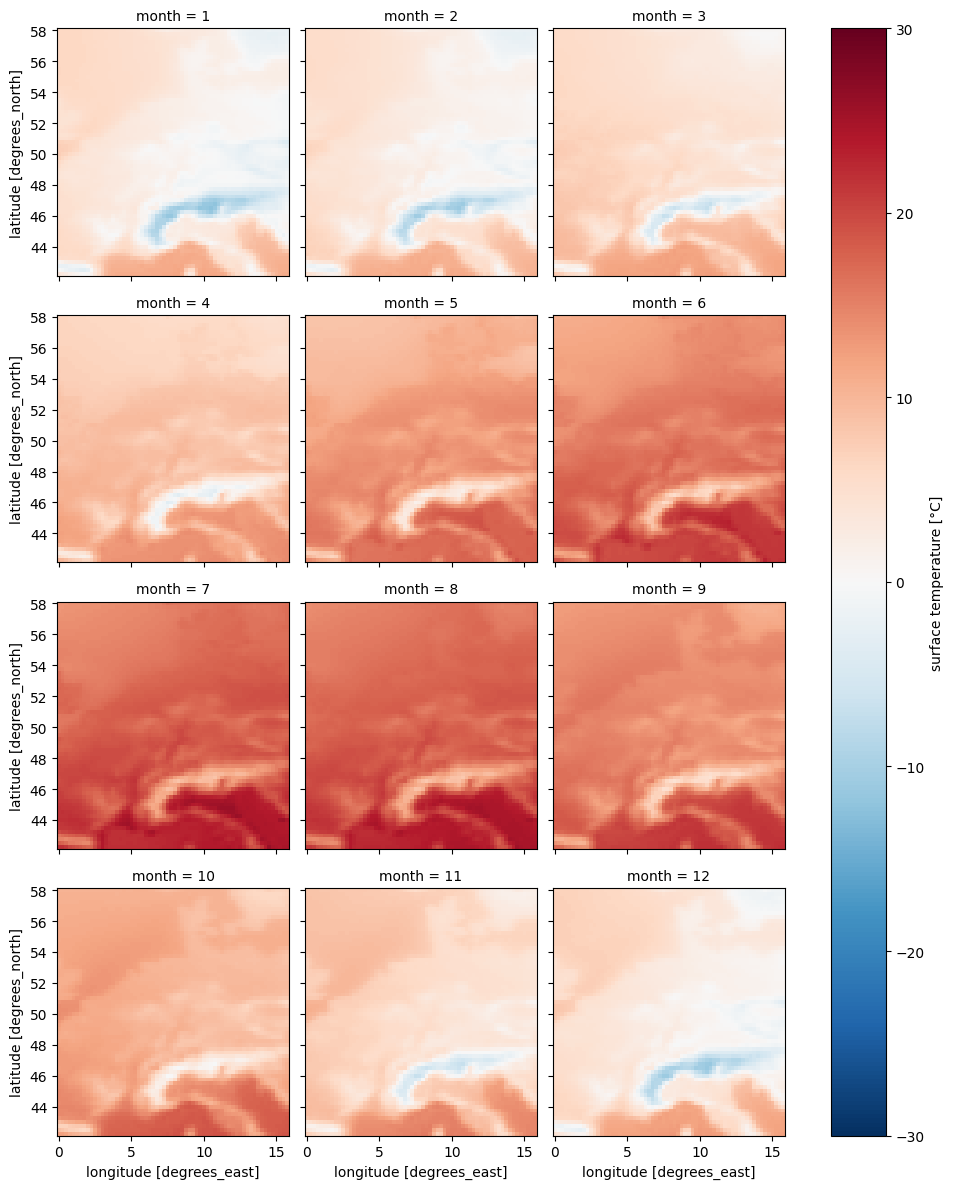

In [11]:
t2m_aoi_toi_month_mean.plot(vmin=-30, col="month", col_wrap=3)

#### Daily climatological mean and quintile extreemes

In [12]:
%%time

t2m_aoi_toi_doy_mean = t2m_aoi_toi_data_C.groupby("valid_time.dayofyear").mean()
t2m_aoi_toi_doy_mean = t2m_aoi_toi_doy_mean.sel(dayofyear=slice(0, 365))
t2m_aoi_toi_doy_mean

CPU times: user 1.45 s, sys: 258 ms, total: 1.71 s
Wall time: 1.75 s


<xarray.DataArray 't2m' (dayofyear: 365, latitude: 64, longitude: 64)> Size: 6MB
array([[[ 6.3420634 ,  6.3111606 ,  6.2635903 , ..., -1.9055634 ,
         -1.95348   , -1.8927159 ],
        [ 6.421578  ,  6.3819947 ,  6.344841  , ..., -2.2319527 ,
         -2.0757024 , -1.9802161 ],
        [ 6.453175  ,  6.4194946 ,  6.3799114 , ..., -1.9746606 ,
         -1.7739638 , -1.7722268 ],
        ...,
        [-1.2767459 , -1.4711922 , -1.5312613 , ..., 11.439997  ,
         11.506315  , 11.590341  ],
        [ 0.42604777, -0.36804944, -0.9191037 , ..., 11.4965925 ,
         11.582006  , 11.641379  ],
        [ 3.5468788 ,  3.315624  ,  2.8982494 , ..., 11.4629135 ,
         11.791028  , 11.804569  ]],

       [[ 6.4128976 ,  6.368106  ,  6.332341  , ..., -2.6354265 ,
         -2.6784823 , -2.5638986 ],
        [ 6.4660225 ,  6.4274807 ,  6.3872027 , ..., -2.9942842 ,
         -2.8211923 , -2.6420245 ],
        [ 6.4875507 ,  6.4587307 ,  6.422967  , ..., -2.7500129 ,
         -2.5260522 , -2.423274  ],
...
        [-1.1316062 , -1.318414  , -1.3399394 , ..., 11.54798   ,
         11.609436  , 11.6649885 ],
        [ 0.5204922 , -0.20346612, -0.8541726 , ..., 11.553536  ,
         11.6469345 , 11.690683  ],
        [ 3.8861244 ,  3.5024333 ,  2.9649198 , ..., 11.496942  ,
         11.840678  , 11.84172   ]],

       [[ 6.558037  ,  6.5128975 ,  6.4757447 , ..., -2.4573    ,
         -2.5262237 , -2.5171955 ],
        [ 6.596232  ,  6.5556064 ,  6.5181065 , ..., -2.858515  ,
         -2.6946273 , -2.6203213 ],
        [ 6.5865097 ,  6.5576897 ,  6.529912  , ..., -2.6635509 ,
         -2.4119875 , -2.3904595 ],
        ...,
        [-1.3974116 , -1.5786655 , -1.6323111 , ..., 11.617074  ,
         11.705958  , 11.8004    ],
        [ 0.44410333, -0.2795078 , -0.8760505 , ..., 11.686515  ,
         11.7879    , 11.859774  ],
        [ 3.7253556 ,  3.4232645 ,  2.9340184 , ..., 11.712556  ,
         12.059073  , 12.05074   ]]], shape=(365, 64, 64), dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * latitude   (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude  (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
Attributes:
    units:      °C
    long_name:  surface temperature

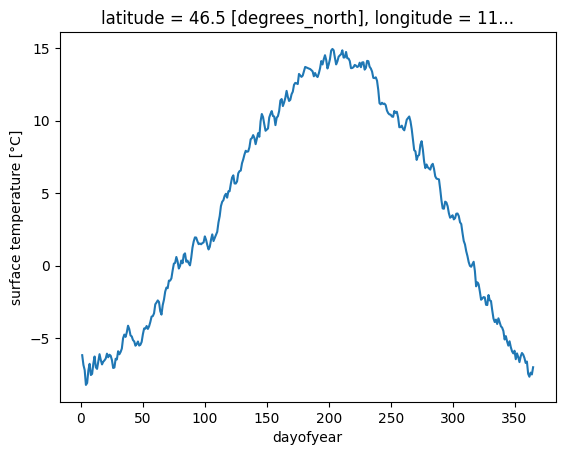

In [13]:
point = {
    "latitude": 46.5,
    "longitude": 11.8,
    "method": "nearest",
}

t2m_point_doy_mean = t2m_aoi_toi_doy_mean.sel(**point)

t2m_point_doy_mean.plot()

In [14]:
%%time

t2m_aoi_toi_doy_quantile = t2m_aoi_toi_data_C.groupby("valid_time.dayofyear").quantile(
    [0.9, 0.5, 0.1]
)
t2m_aoi_toi_doy_quantile = t2m_aoi_toi_doy_quantile.sel(dayofyear=slice(0, 365))
t2m_aoi_toi_doy_quantile

CPU times: user 49.2 s, sys: 946 ms, total: 50.1 s
Wall time: 50.9 s


<xarray.DataArray 't2m' (dayofyear: 365, latitude: 64, longitude: 64,
                         quantile: 3)> Size: 36MB
array([[[[  8.3500061,   6.3500061,   4.1000061],
         [  8.3500061,   6.3500061,   3.8500061],
         [  8.6000061,   6.3500061,   3.8500061],
         ...,
         [  3.6000061,  -1.1499939,  -7.9249939],
         [  3.6000061,  -1.1499939,  -8.1499939],
         [  3.6250061,  -1.1499939,  -8.1499939]],

        [[  8.6000061,   6.6000061,   4.0750061],
         [  8.6000061,   6.3500061,   3.8500061],
         [  8.6000061,   6.3500061,   3.8500061],
         ...,
         [  3.3500061,  -1.3999939,  -8.8999939],
         [  3.3750061,  -1.3999939,  -8.6499939],
         [  3.6000061,  -1.3999939,  -8.6499939]],

        [[  8.6000061,   6.6000061,   4.1000061],
         [  8.6000061,   6.6000061,   3.8500061],
         [  8.6000061,   6.6000061,   3.8500061],
         ...,
...
         [ 14.6000061,  11.8500061,   8.3500061],
         [ 14.6000061,  12.1000061,   8.3500061],
         [ 14.8500061,  12.1000061,   8.5750061]],

        [[  4.6000061,   1.1000061,  -4.3999939],
         [  4.1000061,   0.3500061,  -5.9249939],
         [  3.3500061,  -0.1499939,  -6.6499939],
         ...,
         [ 14.6000061,  11.8500061,   8.6000061],
         [ 14.6250061,  11.8500061,   8.6000061],
         [ 14.8500061,  12.1000061,   8.8500061]],

        [[  8.8500061,   3.8500061,  -1.8999939],
         [  8.6000061,   3.3500061,  -2.1499939],
         [  8.1000061,   3.1000061,  -2.3999939],
         ...,
         [ 14.6000061,  11.8500061,   8.8500061],
         [ 15.1000061,  12.1000061,   9.1000061],
         [ 14.8500061,  12.3500061,   9.3500061]]]],
      shape=(365, 64, 64, 3))
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * latitude   (latitude) float64 512B 58.0 57.75 57.5 ... 42.75 42.5 42.25
  * longitude  (longitude) float64 512B 0.0 0.25 0.5 0.75 ... 15.25 15.5 15.75
  * quantile   (quantile) float64 24B 0.9 0.5 0.1

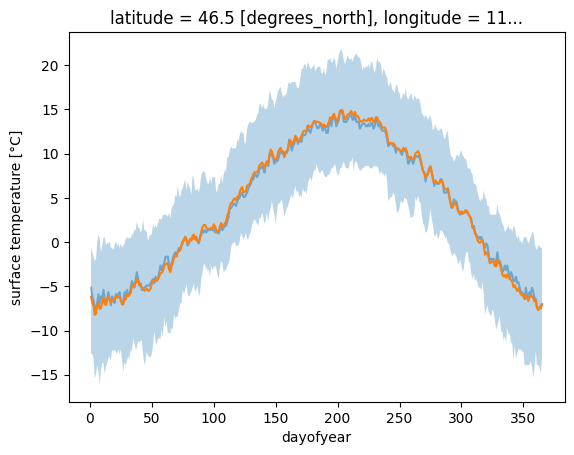

In [15]:
from matplotlib import pyplot as plt

_, ax = plt.subplots()

t2m_point_doy_quantile = t2m_aoi_toi_doy_quantile.sel(**point)

ax.fill_between(
    t2m_point_doy_quantile.dayofyear,
    t2m_point_doy_quantile.sel(quantile=0.9),
    t2m_point_doy_quantile.sel(quantile=0.1),
    alpha=0.3,
)

t2m_point_doy_quantile.sel(quantile=0.5).plot(ax=ax, alpha=0.5)
t2m_point_doy_mean.plot(ax=ax)